In [38]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.txtGraphPruning.graph_clustering import leiden_clustering, mini_graphs_from_clusters, louvain_clustering
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingDeBerta import classify_node_isSentence, classify_node_isCatgory
from Stage2.classifyingEdges.rewritingOPENAI import add_context, summairse, summairse_clusters
from Stage2.classifyingEdges.classifyingOpenAI import classify_needsContext_openAI, classify_link_pairs_openAI, classify_pairwiseEdges_openAI
from Stage2.classifyingEdges.metrics import metrics
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

### Step 1. ###
Load the model and download the website

In [39]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
#htmlFile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [40]:
# Get label edges from text nodes in the website
#sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/0000_test", remove_dupes=REMOVE_DUPES)
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

In [41]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, ",:\\-.%'\\s", lower=False), normalise_text(b, ",:\\-.%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

Extract unique nodes from the edges and create a mapping from node to edge

In [42]:
node_unique_label_index, node_to_edge_pos = np.unique(sorted_label_index, return_index=True)
node_to_edge_pos = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in node_to_edge_pos])
node_to_edge_x_pos, node_to_edge_y_pos = node_to_edge_pos[:,0], node_to_edge_pos[:,1]

node_unique_txts, node_unique_xpaths = txts[node_to_edge_x_pos,node_to_edge_y_pos], xpaths[node_to_edge_x_pos, node_to_edge_y_pos]

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [43]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isButton, buttonTxt = clean_instructional_text(txtsShortened, batch_size=16)
opmask = np.array(isButton, dtype=bool)
mask = np.logical_not(opmask)

print("All the nodes filtered out:\n\n")
isButtonNode = np.zeros_like(node_unique_txts, dtype=bool)
for key, value in buttonTxt.items():
    if value == 1:
        idx = np.where(node_unique_txts==key)
        print(len(idx[0]),"-",key)
        isButtonNode[idx] = True

All the nodes filtered out:


1 - Contact
1 - Privacy Notice
1 - FranceFrance
1 - 5
1 - SpainSpain
1 - About
1 - ArgentinaArgentina
1 - EnglandEngland


In [44]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
node_unique_label_index, node_to_edge_pos, node_unique_txts, node_unique_xpaths = node_unique_label_index[~isButtonNode], node_to_edge_pos[~isButtonNode], node_unique_txts[~isButtonNode], node_unique_xpaths[~isButtonNode]

### Step 4. ###
This filters out all the low probability edges using the finding from the probability paper. At least one edge per node is saved

In [45]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

18906  ->  589


### Step 5. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [46]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=32)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
#print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


In [47]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [48]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [49]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [50]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following edges:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following edges:

 [['Free Spins ZA' 'Bingo Sites UK']
 ['Bingo Sites UK' 'Free Spins ZA']
 ['Andoni IraolaRuud van Nistelrooy' 'Leicester City4-2-3-1']
 ['Andoni IraolaRuud van Nistelrooy' 'AFC Bournemouth4-2-3-1']
 ['A. FatawuACL knee injury' 'Andoni IraolaRuud van Nistelrooy']
 ['Andoni IraolaRuud van Nistelrooy' 'A. FatawuACL knee injury']
 ['L. CookStraight red card' 'Andoni IraolaRuud van Nistelrooy']
 ['Andoni IraolaRuud van Nistelrooy' 'L. CookStraight red card']
 ['Careers' 'Cookie Policy']
 ['D. OuattaraGroin injury' 'Andoni IraolaRuud van Nistelrooy']
 ['Andoni IraolaRuud van Nistelrooy' 'D. OuattaraGroin injury']
 ['News Publishers' 'Cookie Policy']
 ['E. nalCruciate ligament injury' 'Andoni IraolaRuud van Nistelrooy']
 ['Andoni IraolaRuud van Nistelrooy' 'E. nalCruciate ligament injury']
 ['R. ChristieGroin injury' 'Andoni IraolaRuud van Nistelrooy']
 ['Andoni IraolaRuud van Nistelrooy' 'R. ChristieGroin injury']
 ['Corporate' 'Modern Slavery Statement']
 ['H.

### 6. Finding each node that needs context to make a complete fact ###

    1) It uses DeBERTa-v3 model to split the nodes into more than a phrase and less that a phrase

For those that are <b> more than a phrase </b>

    2.1) GPT_4.1_mini decides if the sentences need more context

For those that are <b> less than a phrase </b>

    2.2) Use DeBERTa to categorise the value

The reason they are split is that it is a lot easier to create sentences from small "value to value" pairs. It is also good as the "value to sentence" edges are easier to extract information from if we know which are sentences (that need context) and which are values (that give context).

In [51]:
isSentence, isSentence_probs = classify_node_isSentence(node_unique_txts.tolist(), batch_size=32)
for isS, txt in zip(isSentence, node_unique_txts):
    print(isS, txt)

1 AFC Bournemouth vs Leicester City Live Scores and Match Information
1 The latest football scores, line-ups and more for AFC Bournemouth vs Leicester City.
0 Football
0 Other Sports
0 Trending
0 Betting
0 Casino
0 Careers
0 News Publishers
0 Cookie Policy
0 Terms of Use
1 Modern Slavery Statement
0 Corporate
1 Premier League Scores
1 Premier League Standings
1 La Liga Scores
1 Bundesliga Scores
1 Championship Scores
0 Serie A Scores
0 Cricket Scores
0 Tennis Scores
1 Basketball Scores
1 Ice Hockey Scores
1 Today's Football Scores
1 Football on TV
1 Champions League Scores
1 FA Cup Scores
0 IPL Scores
0 NBA Scores
0 Betting Sites UK
0 Betting Sites IN
0 Betting Sites US
0 NFL Betting Sites
0 Betting Sites ZA
0 Betting Sites CA
0 Casino Sites UK
0 Free Spins UK
0 Bingo Sites UK
0 Free Spins ZA
0 Free Spins US
0 Casino Sites CA
0 FAQ
0 Advertise
0 Scores
0 News
0 Favourites
1 Andoni IraolaRuud van Nistelrooy
1 AFC Bournemouth4-2-3-1
0 Leicester City4-2-3-1
0 RegionEnglandChampions League

In [52]:
isSentence = np.array(isSentence, dtype=bool)
node_sentences, node_sentences_xpaths = node_unique_txts[isSentence], node_unique_xpaths[isSentence]
if len(node_sentences) > 0:
    ####################################################################################################################Random to not waste money
    #sentenceNeedsContext = np.random.randint(2, size=node_sentences.shape)#
    sentenceNeedsContext, cost_needsContext, _ = classify_needsContext_openAI(node_sentences, dry_run_confirm=False, batch_size=1, return_raw_response_and_cost=True)
    ####################################################################################################################
    sentenceNeedsContext=np.array(sentenceNeedsContext, dtype=bool)
    #Re padding and getting back to the dimension of node_unique_txts
else:
    sentenceNeedsContext, cost_needsContext = np.zeros(node_sentences.shape, dtype=bool), 0
padded_sentenceNeedsContext = np.zeros(isSentence.shape, dtype=bool)
padded_sentenceNeedsContext[isSentence] = sentenceNeedsContext
print("Sentences that need context: ", node_unique_txts[padded_sentenceNeedsContext])




Batch 0 ~input tokens=112, ~output tokens=2, est. cost=$0.0007 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 107  {input_tokens= 105  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 4.52e-05  This batch cost: $ 4.52e-05
output so far:  [NEWBATCH]0
results so far:  [0]

Batch 1 ~input tokens=117, ~output tokens=2, est. cost=$0.0007 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 112  {input_tokens= 110  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 9.240000000000001e-05  This batch cost: $ 4.720000000000001e-05
output so far:  [NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0]

Batch 2 ~input tokens=105, ~output tokens=2, est. cost=$0.0007 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 101  {input_tokens= 99  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 0.0001352  This batch cost: $ 4.28e-05
output so far:  [NEWBATCH]0[NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0, 0]

Batch 3 ~input tokens=104, ~output tokens=2, est. cost=$0.0007 (IN=$0.4/1M, OUT=$1.6/1M)
Total_to

In [53]:
node_words = node_unique_txts[~isSentence]
node_words_isCatgory, (_, bestCategory) = classify_node_isCatgory(node_words.tolist())
for idx, (isC, word) in enumerate(zip(node_words_isCatgory, node_words)):
    if not isC:
        bestCategory[idx] = ""
        #print("XX ", word, " XX")
    else:
        pass#print(word, "\t\t->", bestCategory[idx])

padded_node_words_isCatgory = np.zeros(isSentence.shape, dtype=int)
padded_bestCategory =  np.full(isSentence.shape, "", dtype=object)
padded_node_words_isCatgory[~isSentence] = node_words_isCatgory
padded_bestCategory[~isSentence] = bestCategory
for idx, (isC, word) in enumerate(zip(padded_node_words_isCatgory, node_unique_txts)):
    if not isC:
        padded_bestCategory[idx] = ""

### 7a. Focus on Sentences that need Context ###
This decides which sentences to send off for context addition.

Current Sentence filters:
1) isButton
2) isSentence that needs context

<i>(note snall fact nodes will be dealt with through a different pipeline. They go through a different process)</i>

In [54]:
padded_sentenceNeedsContext = np.array(padded_sentenceNeedsContext, dtype=bool)
node_label_NeedsContext = node_unique_label_index[padded_sentenceNeedsContext]
mask = np.isin(sorted_label_index[:,0], node_label_NeedsContext)
needsContext_text_edges, needsContext_xpaths = txts[mask], xpaths[mask]

print("Sentences being checked:")
for idx, isC in enumerate(padded_sentenceNeedsContext):
    if isC:
        print(node_unique_txts[idx])

Sentences being checked:
Today's Football Scores
A. FatawuACL knee injury


In [55]:
# Compute all pairwise-edges
# Creating an array of [SENTENCE, CTX1, CTX2] to compare them

outputs_by_input = {}
for inp, out in needsContext_text_edges:
    outputs_by_input.setdefault(inp, []).append(out)

needsContext_allPairwise_text = []
for inp, outs in outputs_by_input.items():
    if len(outs) < 2:
        continue  # need at least two outputs to form a pair

    pair_iter = combinations(outs, 2)
    for c1, c2 in pair_iter:
        needsContext_allPairwise_text.append([inp, c1, c2])
needsContext_allPairwise_text = np.array(needsContext_allPairwise_text)
print(len(needsContext_allPairwise_text))
print(needsContext_text_edges)

15
[["Today's Football Scores" 'Football on TV']
 ["Today's Football Scores" 'Trending']
 ["Today's Football Scores" 'Champions League Scores']
 ["Today's Football Scores" 'FA Cup Scores']
 ["Today's Football Scores" 'IPL Scores']
 ["Today's Football Scores" 'NBA Scores']
 ['A. FatawuACL knee injury' 'L. CookStraight red card']]


In [56]:
print(needsContext_text_edges)

[["Today's Football Scores" 'Football on TV']
 ["Today's Football Scores" 'Trending']
 ["Today's Football Scores" 'Champions League Scores']
 ["Today's Football Scores" 'FA Cup Scores']
 ["Today's Football Scores" 'IPL Scores']
 ["Today's Football Scores" 'NBA Scores']
 ['A. FatawuACL knee injury' 'L. CookStraight red card']]


In [57]:
BATCH_SIZE = 4
# expects: needsContext_allPairwise_text = [[INPUT, OUT1, OUT2], ...]

# Work on a mutable copy; keep as generic objects (strings/ints/etc.)
remaining = [list(t) for t in needsContext_allPairwise_text]
removedEdges = []

def _choose_smaller(inp, o1, o2):
    prob_1 = probs[((txts[:,0] == inp) & (txts[:,1] == o1))][0]
    prob_2 = probs[((txts[:,0] == inp) & (txts[:,1] == o2))][0]
    if prob_1 < prob_2: return o1
    if prob_2 < prob_1: return o2
    # tie
    return None  # "keep" => don't drop on ties

runningCost_pairwiseEdges = 0
while remaining:
    batch = remaining[:BATCH_SIZE]
    labels, cost, _ = list(classify_pairwiseEdges_openAI(batch, False, 4, True))
    runningCost_pairwiseEdges += cost
    print("Running cost: $", runningCost_pairwiseEdges)
    if len(labels) != len(batch):
        raise ValueError("Classifier must return one label per triplet in the batch.")

    # Advance the window
    remaining = remaining[len(batch):]

    # For any label==0, note which outputs to drop for that INPUT
    drop_by_input = defaultdict(set)

    for triplet, y in zip(batch, labels):
        inp, o1, o2 = triplet
        print(o1)
        print(o2)
        print(y)
        print()
        if y == 0: # 0 means o1 and o2 are similar
            small = _choose_smaller(inp, o1, o2)
            if small:
                drop_by_input[inp].add(small)
                
                # Remove [inp, small] from the array edges we are considering
                mask = ~((needsContext_text_edges[:,0] == inp) & (needsContext_text_edges[:,1] == small))
                removedEdges.extend(needsContext_text_edges[~mask])
                needsContext_text_edges, needsContext_xpaths = needsContext_text_edges[mask], needsContext_xpaths[mask]

    # Filter out future triplets containing the marked outputs for the same INPUT
    if drop_by_input:
        new_remaining = []
        for t in remaining:
            inp, o1, o2 = t
            drop_set = drop_by_input.get(inp)
            if drop_set and (o1 in drop_set or o2 in drop_set):
                continue  # remove this triplet from consideration
            new_remaining.append(t)
        remaining = new_remaining

print("Removed ", removedEdges)


Batch 0 ~input tokens=164, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 164  {input_tokens= 156  reasoning_tokens= 0  output_tokens= 8 }
Running Total cost: $ 7.52e-05  This batch cost: $ 7.52e-05
output so far:  [NEWBATCH]1 0 0 1
results so far:  [1, 0, 0, 1]
Running cost: $ 7.52e-05
Football on TV
Trending
1

Football on TV
Champions League Scores
0

Football on TV
FA Cup Scores
0

Football on TV
IPL Scores
1


Batch 0 ~input tokens=159, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 158  {input_tokens= 150  reasoning_tokens= 0  output_tokens= 8 }
Running Total cost: $ 7.28e-05  This batch cost: $ 7.28e-05
output so far:  [NEWBATCH]1 1 1 0
results so far:  [1, 1, 1, 0]
Running cost: $ 0.000148
Football on TV
NBA Scores
1

Trending
IPL Scores
1

Trending
NBA Scores
1

IPL Scores
NBA Scores
0

Removed  [array(["Today's Football Scores", 'Champions League Scores'], dtype='<U84'), array(["Today's Football Scores", 'FA Cup Score

In [58]:
print(len(needsContext_text_edges), len(node_sentences[~sentenceNeedsContext]))
facts_context, cost_add_context = add_context(needsContext_text_edges, dry_run_confirm=False, return_raw_response_and_cost=True)
facts_noContext, cost_summarise = summairse(node_sentences[~sentenceNeedsContext], dry_run_confirm=False, return_raw_response_and_cost=True)

print(facts_context)
print(facts_noContext)
print("Cost: $",cost_add_context+cost_summarise)

4 17

Batch 1 (pairs 0..0): ~input tokens=127, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 145  {input_tokens= 141  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 1.5700000000000002e-05  This batch cost: $ 1.5700000000000002e-05
results so far:  ['NO FACTS']

Batch 2 (pairs 1..1): ~input tokens=126, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 143  {input_tokens= 139  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 3.12e-05  This batch cost: $ 1.5499999999999997e-05
results so far:  ['NO FACTS', 'NO FACTS']

Batch 3 (pairs 2..2): ~input tokens=126, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 144  {input_tokens= 140  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 4.68e-05  This batch cost: $ 1.56e-05
results so far:  ['NO FACTS', 'NO FACTS', 'NO FACTS']

Batch 4 (pairs 3..3): ~input tokens=1

In [59]:
LISTOFFACTS = []
LISTOFXPATHS = []
for fact, xp in zip(facts_context, needsContext_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append(xp)

for fact, xp in zip(facts_noContext, node_sentences_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append([xp])

for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[1]/a']

AFC Bournemouth uses a 4-2-3-1 formation.
[np.str_('/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[10]')]

L. Sinisterra has a hamstring strain.
[np.str_('/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[2]/span[1]')]

H. Souttar has an Achilles tendon injury.
[np.str_('/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[1]/div[1]/a')]



In [60]:
for idx, fact in enumerate(facts_context):
    print(needsContext_text_edges[idx])
    print("\t", fact)
print()
for idx, fact in enumerate(facts_noContext):
    print("\t",node_sentences[~sentenceNeedsContext][idx])
    print(fact)

["Today's Football Scores" 'Football on TV']
	 NO FACTS
["Today's Football Scores" 'Trending']
	 NO FACTS
["Today's Football Scores" 'IPL Scores']
	 NO FACTS
['A. FatawuACL knee injury' 'L. CookStraight red card']
	 A. Fatawu has an ACL knee injury.

	 AFC Bournemouth vs Leicester City Live Scores and Match Information
NO FACTS
	 The latest football scores, line-ups and more for AFC Bournemouth vs Leicester City.
NO FACTS
	 Modern Slavery Statement
NO FACTS
	 Premier League Scores
NO FACTS
	 Premier League Standings
NO FACTS
	 La Liga Scores
NO FACTS
	 Bundesliga Scores
NO FACTS
	 Championship Scores
NO FACTS
	 Basketball Scores
NO FACTS
	 Ice Hockey Scores
NO FACTS
	 Football on TV
NO FACTS
	 Champions League Scores
NO FACTS
	 FA Cup Scores
NO FACTS
	 Andoni IraolaRuud van Nistelrooy
NO FACTS
	 AFC Bournemouth4-2-3-1
AFC Bournemouth uses a 4-2-3-1 formation.
	 L. SinisterraHamstring strain
L. Sinisterra has a hamstring strain.
	 H. SouttarAchilles tendon injury
H. Souttar has an Achil

### 7b. Cluster the non sentence nodes together ###
This uses Leiden clustering. Louvain also available

This makes a new, simple classification of sentence as "more than x words" (instead of that above using FLAN-T5)

In [61]:
#To still do: Link all the small text nodes
#Output XPaths so we know where the nodes came from
NUMWORDSPERSENTENCE = 7
manyWordsMask = np.zeros(len(sorted_label_index), dtype=bool)
for idx, (first, second) in enumerate(txts):
    if len(first.split()) > NUMWORDSPERSENTENCE or len(second.split()) > NUMWORDSPERSENTENCE:
        manyWordsMask[idx] = True

no_sent_label_index, no_sent_txts, no_sent_probs, no_sent_xpaths = sorted_label_index[~manyWordsMask], txts[~manyWordsMask], probs[~manyWordsMask], xpaths[~manyWordsMask]

node_meta = defaultdict(lambda: {"texts": set(), "xpaths": set()})
for (u, v), (t1, t2), (x1, x2) in zip(no_sent_label_index, no_sent_txts, no_sent_xpaths):
    node_meta[u]["texts"].add(t1); node_meta[u]["xpaths"].add(x1)
    node_meta[v]["texts"].add(t2); node_meta[v]["xpaths"].add(x2)

clusters = leiden_clustering(no_sent_label_index, no_sent_probs)
clusters = [cluster[::-1] for cluster in clusters] #Reorder as the output above seems to put titles at the bottom

FitnessResult(min=None, max=None, score=0.814749931610913, std=None)


In [62]:
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i} -> nodes: {cluster}")
    for n in cluster:
        t = ", ".join(node_meta[n]["texts"])
        #print(f"    - Node {n}: text=[{t}]")
        print("\"",t,"\"", sep="", end=",\n")

  Cluster 0 -> nodes: [641, 636, 644, 643, 642, 637, 638, 640, 639, 629, 630, 394, 708, 393, 706, 694, 690, 700, 686, 432, 429, 212, 395, 392, 490, 489, 494, 493, 478, 477, 474, 473, 162, 176, 174]
"33L. Thomas",
"16V. Kristiansen",
"2J. Justin",
"4C. Coady",
"3W. Faes",
"18J. Ayew",
"35K. McAteer",
"22O. Skipp",
"24B. Soumar",
"12T. Adams",
"16M. Tavernier",
"R. ChristieGroin injury",
"40",
"M. HermansenGroin injury",
"8",
"20",
"2",
"77",
"40",
"Leicester City",
"AFC Bournemouth",
"Premier League 2425England",
"B. Decordova-ReidMuscle injury",
"L. SinisterraHamstring strain",
"A. Scott",
"Evanilson",
"J. Evans",
"K. McAteer",
"J. Monga",
"L. Thomas",
"D. Huijsen",
"M. Senesi",
"Andoni IraolaRuud van Nistelrooy",
"Leicester City4-2-3-1",
"AFC Bournemouth4-2-3-1",
  Cluster 1 -> nodes: [103, 100, 58, 57, 56, 55, 54, 59]
"Advertise",
"FAQ",
"Modern Slavery Statement",
"Terms of Use",
"Cookie Policy",
"News Publishers",
"Careers",
"Corporate",
  Cluster 2 -> nodes: [85, 84, 80, 83, 81, 4

Tried extra clustering within clusters but it didn't add much. Would of had to be fine tuned per website to give any useful information. semantic grouping would have been much better

In [63]:
mini_graphs, mini_probs = mini_graphs_from_clusters(no_sent_label_index, no_sent_probs, clusters)
# mini_clusters = []
# for g, p in zip(mini_graphs, mini_probs):
#     print(g)
#     mini_cluster = louvain_clustering(g, p, 1.2)
#     print(mini_cluster)
#     print()
#     mini_clusters.append(mini_cluster)

In [64]:
# for clusters in mini_clusters:
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i} -> nodes: {cluster}")
#         for n in cluster:
#             t = ", ".join(node_meta[n]["texts"])
#             #print(f"    - Node {n}: text=[{t}]")
#             print("\"",t,"\"", sep="", end=",\n")

Tried rudimentury grouping within clusters using an llm, but it didn't work too well enough to justify the cost

In [65]:
# clusters_text = [[". ".join(node_meta[n]["texts"]) for n in cluster] for cluster in clusters]
# clusters_xpaths = [[". ".join(node_meta[n]["xpaths"]) for n in cluster] for cluster in clusters]
# print(clusters_text)

In [66]:
# cluster_summaries, cost = summairse_clusters(clusters_text, dry_run_confirm=False, return_raw_response_and_cost=True)
# print("Cost: $",cost)
# print(cluster_summaries)

In [67]:
# for model_outputs in cluster_summaries:
#     model_cluster = model_outputs.split("\n")
#     for m in model_cluster:
#         entries = m.strip().split(" | ")
#         print(entries)

### 8. Final fact output ###
Outputing all the facts and groupings found, with xpaths to lead back to the source

In [68]:
# total cost
cost_add_context + cost_summarise + runningCost_pairwiseEdges + cost_needsContext

0.0013038

In [69]:
new_edges = []
new_txts = []
new_xpaths = []
new_probs = []
for g, p in zip(mini_graphs, mini_probs):
    for edge, prob in zip(g, p):
        u, v = edge
        if [int(u), int(v)] not in sorted_label_index.tolist() and [int(v), int(u)] not in sorted_label_index.tolist():
            print(edge, "not found", end=", ")
            continue
        u_txt, u_xpath = "|".join(node_meta[u]["texts"]), "|".join(node_meta[u]["xpaths"])
        v_txt, v_xpath = "|".join(node_meta[v]["texts"]), "|".join(node_meta[v]["xpaths"])
        new_edges.append(edge)
        new_txts.append([u_txt, v_txt])
        new_xpaths.append([u_xpath, v_xpath])
        new_probs.append(prob)
print()
new_edges, new_txts, new_xpaths, new_probs = np.array(new_edges), np.array(new_txts), np.array(new_xpaths), np.array(new_probs)
print(new_edges)
print(new_txts)
print(new_xpaths)
print(new_probs)


[[640 639]
 [641 643]
 [641 644]
 [641 642]
 [642 162]
 [642 643]
 [642 644]
 [643 162]
 [643 644]
 [392 162]
 [392 393]
 [394 395]
 [395 162]
 [162 176]
 [162 174]
 [162 212]
 [162 429]
 [162 432]
 [162 686]
 [162 700]
 [162 494]
 [162 690]
 [162 694]
 [162 493]
 [162 706]
 [162 474]
 [162 708]
 [162 477]
 [162 639]
 [162 638]
 [162 630]
 [429 432]
 [429 174]
 [174 176]
 [174 212]
 [174 432]
 [473 474]
 [473 478]
 [474 478]
 [474 477]
 [477 478]
 [489 490]
 [489 494]
 [490 494]
 [493 494]
 [629 630]
 [636 637]
 [637 638]
 [100 103]
 [103  59]
 [103  54]
 [ 54  59]
 [ 54  55]
 [ 54  56]
 [ 54  58]
 [ 54  57]
 [ 55  59]
 [ 55  56]
 [ 55  58]
 [ 55  57]
 [ 56  59]
 [ 56  57]
 [ 57  59]
 [ 57  58]
 [ 58  59]
 [ 46  82]
 [ 46  81]
 [ 46  83]
 [ 46  80]
 [ 46  84]
 [ 46  85]
 [ 80  81]
 [ 80  82]
 [ 80  83]
 [ 80  84]
 [ 80  85]
 [ 81  82]
 [ 81  83]
 [ 81  84]
 [ 81  85]
 [ 82  83]
 [ 82  84]
 [ 82  85]
 [ 83  84]
 [ 83  85]
 [ 84  85]
 [ 96  50]
 [ 96  94]
 [ 96  95]
 [ 96  93]
 [ 96  92

In [70]:
for i, cluster in enumerate(clusters):
    textInCluster, xpathInCluster = [], []
    for n in cluster:
        t, xp = ", ".join(node_meta[n]["texts"]), ", ".join(node_meta[n]["xpaths"])
        textInCluster.append(t)
        xpathInCluster.append(xp)
    LISTOFFACTS.append(textInCluster)
    LISTOFXPATHS.append(xpathInCluster)
        

In [71]:
for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[1]/a']

AFC Bournemouth uses a 4-2-3-1 formation.
[np.str_('/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[10]')]

L. Sinisterra has a hamstring strain.
[np.str_('/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[2]/span[1]')]

H. Souttar has an Achilles tendon injury.
[np.str_('/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[1]/div[1]/a')]

['33L. Thomas', '16V. Kristiansen', '2J. Justin', '4C. Coady', '3W. Faes', '18J. Ayew', '35K. McAteer', '22O. Skipp', '24B. Soumar', '12T. Adams', '16M. Tavernier', 'R. ChristieGroin injury', '40', 'M. HermansenGroin injury', '8', '20', '2', '77', '40', 'Leicester City', 'AFC Bournemouth', 'Premier League 2425England', 'B. Decordova-ReidMuscle injury', 'L. SinisterraHamstrin

### Final edge output ###
Here are the results after all the filtering


['22O. Skipp' '24B. Soumar']
['33L. Thomas' '4C. Coady']
['33L. Thomas' '2J. Justin']
['33L. Thomas' '3W. Faes']
['3W. Faes' 'Andoni IraolaRuud van Nistelrooy']
['3W. Faes' '4C. Coady']
['3W. Faes' '2J. Justin']
['4C. Coady' 'Andoni IraolaRuud van Nistelrooy']
['4C. Coady' '2J. Justin']
['L. SinisterraHamstring strain' 'Andoni IraolaRuud van Nistelrooy']
['L. SinisterraHamstring strain' 'M. HermansenGroin injury']
['R. ChristieGroin injury' 'B. Decordova-ReidMuscle injury']
['B. Decordova-ReidMuscle injury' 'Andoni IraolaRuud van Nistelrooy']
['Andoni IraolaRuud van Nistelrooy' 'Leicester City4-2-3-1']
['Andoni IraolaRuud van Nistelrooy' 'AFC Bournemouth4-2-3-1']
['Andoni IraolaRuud van Nistelrooy' 'Premier League 2425England']
['Andoni IraolaRuud van Nistelrooy' 'AFC Bournemouth']
['Andoni IraolaRuud van Nistelrooy' 'Leicester City']
['Andoni IraolaRuud van Nistelrooy' '40']
['Andoni IraolaRuud van Nistelrooy' '77']
['Andoni IraolaRuud van Nistelrooy' 'J. Evans']
['Andoni IraolaRuud v

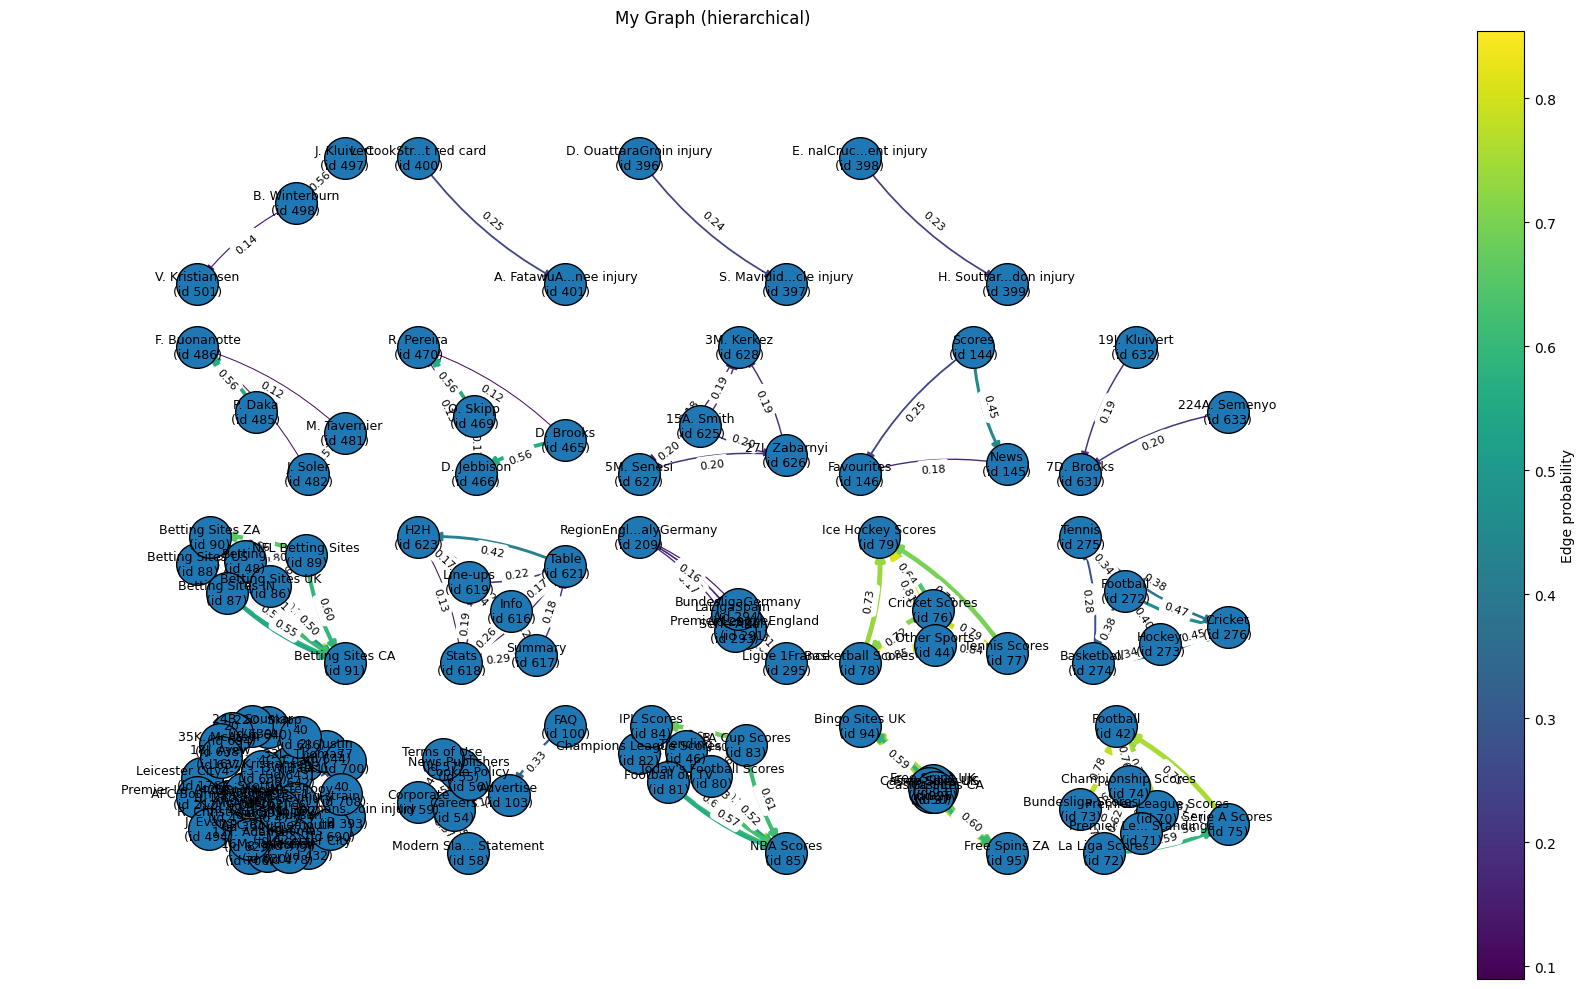

{'G': <networkx.classes.digraph.DiGraph at 0x7519f561e630>,
 'pos': {640: (np.float64(0.47907685771827935),
   np.float64(0.9958595765532665)),
  641: (np.float64(0.7198489332895052), np.float64(0.7256314260542188)),
  642: (np.float64(0.6345355648952206), np.float64(0.6152785298982869)),
  643: (np.float64(0.6276275703919268), np.float64(0.6765083612685889)),
  644: (np.float64(0.8746485993923641), np.float64(0.8016364281537478)),
  392: (np.float64(0.6705344642295442), np.float64(0.3908203046963947)),
  393: (np.float64(0.9924067393923321), np.float64(0.28849265736123314)),
  394: (np.float64(0.32510003150765343), np.float64(0.2668614300236919)),
  395: (np.float64(0.4488342049019671), np.float64(0.3803242940866888)),
  162: (np.float64(0.4485396459616102), np.float64(0.4464665372037956)),
  429: (np.float64(0.5437914792666609), np.float64(0.16349552110716245)),
  174: (np.float64(0.2216992803376527), np.float64(0.41117806607981694)),
  686: (np.float64(0.6971030473516748), np.float6

In [72]:
# Display the graph
textmask = np.array([True]*len(new_txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(new_edges[textmask][:numToShow], new_xpaths[textmask][:numToShow], new_txts[textmask][:numToShow], new_probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=new_txts[textmask][:numToShow],
    id_edge_pairs=new_edges[textmask][:numToShow],
    xpath_edge_pairs=new_xpaths[textmask][:numToShow],
    probs=new_probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)